<a href="https://colab.research.google.com/github/hasibulhshovo/COMP432/blob/main/lab7/lab_7_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Mixture Models (GMM)

**What you’ll do:** generate synthetic data, implement a *from‑scratch* EM for an isotropic GMM, compare to `scikit-learn`, visualize responsibilities, and explore model selection (BIC/AIC).

### Learning Objectives
By the end of this lab, you should be able to:
1. Explain the probabilistic view of clustering and why GMMs address k‑means’ “circular clusters” limitation.
2. Derive and implement the **E‑step** and **M‑step** for an isotropic GMM ($\Sigma_k = \sigma_k^2 I$ or $I$ in our simplification).
3. Track **log‑likelihood** and diagnose EM convergence / local optima.
4. Use `GaussianMixture` from `scikit-learn`, visualize results, and compare with our implementation.
5. Use **BIC**/**AIC** to pick $K$.

## 0. Setup

Import packages and set a stable random seed for reproducibility.

In [1]:
# Import necessary libraries
import numpy as np                      # NumPy for numerical computations and array handling
import matplotlib.pyplot as plt          # Matplotlib for plotting and data visualization

# Import dataset generators and clustering algorithms from scikit-learn
from sklearn.datasets import make_blobs, make_moons   # Functions to create synthetic datasets
from sklearn.cluster import KMeans                    # K-Means clustering algorithm
from sklearn.mixture import GaussianMixture           # Gaussian Mixture Model (GMM) clustering algorithm
from sklearn.metrics import silhouette_score          # Metric to evaluate clustering quality

# Set random seed for reproducibility
np.random.seed(7)  # Ensures consistent random results each time the code is run

## 1. Theory Recap

We assume data points $x \in \mathbb{R}^d\$ are generated by a mixture of \(K\) Gaussians:

$p(x) = \sum_{k=1}^K \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k)$,

where $\pi_k \ge 0$, $\sum_k \pi_k = 1$. The hidden variable $z\in\{1,\ldots,K\}$ indicates which component generated $x$.

**Responsibilities (posterior over components):**
$
r_{ik} \equiv p(z_i = k \mid x_i) \,=\, \frac{\pi_k\,\mathcal{N}(x_i\mid\mu_k,\Sigma_k)}{\sum_{j=1}^{K} \pi_j\,\mathcal{N}(x_i\mid\mu_j,\Sigma_j)}.
$

**EM Algorithm:**
- **E‑step:** compute $r_{ik}$ given current parameters.
- **M‑step:** update parameters using soft counts $N_k = \sum_i r_{ik}$:  
  $\mu_k \leftarrow \frac{1}{N_k}\sum_i r_{ik} x_i$,  
  $\pi_k \leftarrow \frac{N_k}{N}$,  
  and if learning isotropic variances $\sigma_k^2$:  
  $\sigma_k^2 \leftarrow \frac{1}{d N_k}\sum_i r_{ik}\,\lVert x_i - \mu_k \rVert^2$.

> In this lab we’ll implement the **isotropic** case $(\Sigma_k = \sigma_k^2 I$).

## 2. Build a Non‑Circular Dataset

We’ll make a 2‑D dataset that violates the “circular cluster” assumption.

Data shape: (1200, 2)


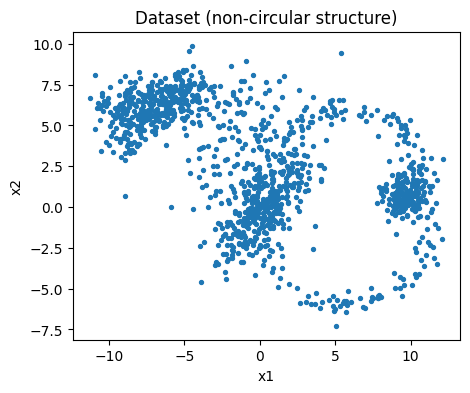

In [2]:
def make_non_circular(n1=300, n2=300, n3=300, random_state=7):
    """
    Generate a custom non-circular dataset composed of three distinct clusters:
    - Cluster A: an elongated Gaussian blob
    - Cluster B: a noisy ring structure
    - Cluster C: a compact Gaussian blob elsewhere
    """
    rng = np.random.default_rng(random_state)  # Random number generator for reproducibility

    # ----- Component A: elongated Gaussian cluster -----
    mean_a = np.array([0.0, 0.0])  # Center of the Gaussian
    C = np.array([[3.0, 2.4],
                  [2.4, 3.5]])  # Covariance matrix to control elongation and orientation
    Xa = rng.multivariate_normal(mean_a, C, size=n1)  # Sample n1 points from this distribution

    # ----- Component B: approximate ring-shaped cluster -----
    theta = rng.uniform(0, 2*np.pi, size=n2)             # Random angles around a circle
    radius = 6.0 + rng.normal(scale=0.5, size=n2)        # Add noise to the radius for irregular shape
    # Convert polar coordinates (radius, theta) to Cartesian (x, y) and shift to the right
    Xb = np.stack([radius*np.cos(theta), radius*np.sin(theta)], axis=1) + np.array([5.5, 0.0])

    # ----- Component C: compact Gaussian cluster -----
    mean_c = np.array([-6.0, 6.5])  # Center of this Gaussian
    Cc = np.array([[1.2, 0.3],
                   [0.3, 0.8]])     # Covariance matrix for small spread
    Xc = rng.multivariate_normal(mean_c, Cc, size=n3)  # Sample n3 points

    # Combine all components into a single dataset
    X = np.vstack([Xa, Xb, Xc])
    rng.shuffle(X, axis=0)  # Shuffle data to mix points from different clusters
    return X


# ----- Create the dataset -----
if 'make_blobs' in globals():  # If make_blobs is available (imported earlier)
    # Generate a simple blob dataset
    X_blobs, _ = make_blobs(
        n_samples=500,
        centers=3,
        cluster_std=[1.2, 2.5, 0.8],
        random_state=7
    )

    # Combine the blob dataset with the custom non-circular dataset
    X = np.vstack([X_blobs, make_non_circular(300, 200, 200)])
else:
    # Fallback: only use the custom non-circular dataset
    X = make_non_circular()

print('Data shape:', X.shape)  # Display total number of points and dimensions

# ----- Visualization -----
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1], s=8)  # Plot data points
plt.title('Dataset (non-circular structure)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## 3. Baseline: k‑Means (hard assignments)

We’ll use k‑means as a baseline for clustering quality and initialization. Notice how it tends to form spherical/circular Voronoi regions.

KMeans inertia: 11227.534049687663


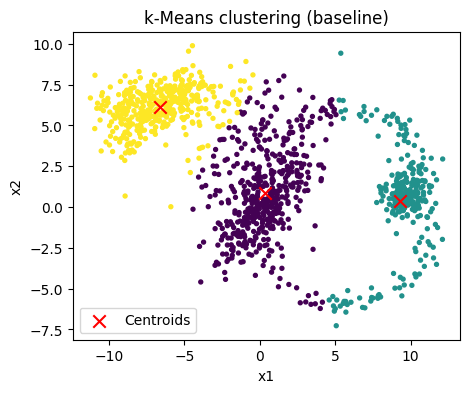

In [3]:
# ----- Baseline clustering with k-Means -----
K = 3  # Number of clusters (we expect roughly 3 groups in the data)

# Check if KMeans is available (imported earlier)
if 'KMeans' in globals():
    # Initialize the K-Means clustering model
    kmeans = KMeans(
        n_clusters=K,     # Number of clusters to form
        n_init=10,        # Number of times the algorithm will run with different centroid seeds
        random_state=7    # Random seed for reproducibility
    )

    # Fit the K-Means model to the data and get cluster labels for each point
    labels_km = kmeans.fit_predict(X)

    # Retrieve the coordinates of cluster centers (centroids)
    centers_km = kmeans.cluster_centers_

    # Get the final inertia (sum of squared distances of samples to their nearest cluster center)
    inertia = kmeans.inertia_
    print('KMeans inertia:', inertia)

    # ----- Visualization of clustering results -----
    plt.figure(figsize=(5, 4))
    plt.scatter(
        X[:, 0], X[:, 1],
        s=8, c=labels_km, cmap='viridis'
    )  # Plot data points colored by cluster assignment

    plt.scatter(
        centers_km[:, 0], centers_km[:, 1],
        marker='x', s=80, color='red', label='Centroids'
    )  # Mark cluster centers with red X’s

    plt.title('k-Means clustering (baseline)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()

else:
    # In case scikit-learn (and thus KMeans) is not available
    print('scikit-learn not available: skipping k-means baseline.')

## 4. From‑Scratch EM for an **Isotropic** GMM

We implement:
- numerically stable log‑pdf for isotropic Gaussians,
- E‑step (responsibilities via log‑sum‑exp),
- M‑step $(\mu_k$, $\pi_k$, and $\sigma_k^2$),
- convergence by log‑likelihood improvement.

We also optionally initialize with k‑means.

Learned mixing proportions (pi): [0.52943315 0.15875419 0.31181265]
Learned variances (per component): [12.06126665  0.8699781   2.33388783]
Means shape: (3, 2)


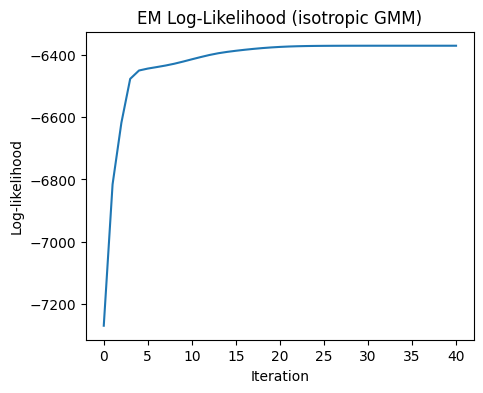

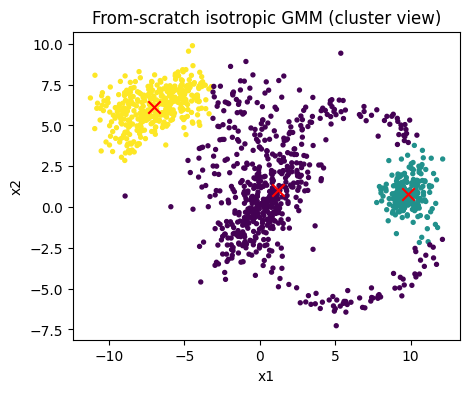

In [4]:
def log_gaussian_isotropic(X, mu, var):
    """
    Compute log N(x | mu, var*I) for all rows in X, given a single Gaussian component.

    Parameters:
        X: (N, d) array of data points
        mu: (d,) mean vector of the Gaussian
        var: scalar, variance (same for all dimensions, isotropic)

    Returns:
        (N,) array of log-probability densities for each sample under this component
    """
    d = X.shape[1]                    # Dimensionality of the data
    diff = X - mu                     # Compute difference from the mean
    # Log of the Gaussian density under isotropic assumption
    return -0.5 * (d*np.log(2*np.pi) + d*np.log(var) + (diff*diff).sum(axis=1)/var)


def em_gmm_isotropic(X, K, max_iter=200, tol=1e-4, init='kmeans', random_state=7):
    """
    Expectation-Maximization algorithm for a Gaussian Mixture Model (GMM)
    with isotropic covariance matrices.

    Learns parameters:
      - pi_k : mixing proportions
      - mu_k : cluster means
      - var_k: isotropic variances (one per cluster)

    Returns a dictionary containing:
      - pi, mu, var, responsibilities, labels, log_likelihoods
    """
    rng = np.random.default_rng(random_state)
    N, d = X.shape  # Number of samples and dimensions

    # ----- Initialization -----
    if init == 'kmeans' and 'KMeans' in globals():
        # Use K-Means to get initial cluster centers
        km = KMeans(n_clusters=K, n_init=10, random_state=random_state)
        labels = km.fit_predict(X)
        mu = km.cluster_centers_.copy()
    else:
        # Random initialization: pick K random data points as initial means
        idx = rng.choice(N, size=K, replace=False)
        mu = X[idx].copy()
        labels = None

    # Initialize mixing proportions equally
    pi = np.full(K, 1.0 / K)

    # Initialize variances using overall dataset variance
    global_var = np.var(X, axis=0).mean()
    var = np.full(K, global_var if global_var > 1e-6 else 1.0)

    log_liks = []  # To store log-likelihood per iteration

    # ----- EM Iterations -----
    for it in range(max_iter):
        # ===== E-step: compute responsibilities =====
        log_resp = np.zeros((N, K))  # Log-responsibility matrix (N x K)

        # Compute log posterior (unnormalized) for each component
        for k in range(K):
            log_resp[:, k] = np.log(pi[k] + 1e-12) + log_gaussian_isotropic(X, mu[k], var[k])

        # Log-sum-exp trick for numerical stability
        max_log = np.max(log_resp, axis=1, keepdims=True)
        log_sum_exp = max_log + np.log(np.exp(log_resp - max_log).sum(axis=1, keepdims=True))

        # Normalize responsibilities
        log_r = log_resp - log_sum_exp
        r = np.exp(log_r)  # Convert back from log-space

        # Compute log-likelihood for convergence tracking
        ll = float(np.sum(log_sum_exp))
        log_liks.append(ll)

        # ===== M-step: update parameters =====
        Nk = r.sum(axis=0) + 1e-12      # Effective number of points per cluster
        pi = Nk / N                     # Update mixing proportions
        mu = (r.T @ X) / Nk[:, None]    # Update means

        # Update isotropic variances
        var_new = np.zeros(K)
        for k in range(K):
            diff = X - mu[k]
            var_new[k] = (r[:, k] * (diff*diff).sum(axis=1)).sum() / (Nk[k] * d)
            # Prevent numerical collapse (variance → 0)
            if var_new[k] < 1e-8:
                var_new[k] = 1e-8
        var = var_new

        # Check for convergence (change in log-likelihood below tolerance)
        if it > 0 and abs(log_liks[-1] - log_liks[-2]) < tol:
            break

    # Assign each data point to the most likely cluster
    labels_soft = np.argmax(r, axis=1)

    # Return learned parameters and diagnostics
    return {
        'pi': pi, 'mu': mu, 'var': var,
        'responsibilities': r,
        'labels': labels_soft,
        'log_likelihoods': log_liks
    }


# ----- Train our isotropic GMM -----
K = 3
gmm_iso = em_gmm_isotropic(
    X,
    K=K,
    init='kmeans' if ('KMeans' in globals()) else 'random',
    max_iter=300
)

# Display learned parameters
print('Learned mixing proportions (pi):', gmm_iso['pi'])
print('Learned variances (per component):', gmm_iso['var'])
print('Means shape:', gmm_iso['mu'].shape)

# ----- Plot log-likelihood progression -----
plt.figure(figsize=(5, 4))
plt.plot(gmm_iso['log_likelihoods'])
plt.title('EM Log-Likelihood (isotropic GMM)')
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()

# ----- Visualize GMM clustering results -----
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1], s=8, c=gmm_iso['labels'], cmap='viridis')
plt.scatter(gmm_iso['mu'][:, 0], gmm_iso['mu'][:, 1], marker='x', s=80, color='red')
plt.title('From-scratch isotropic GMM (cluster view)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## 5. Compare with `scikit‑learn` `GaussianMixture`

We’ll fit both **diagonal** and **full** covariance variants and visualize decision structure via contours. This highlights how GMMs adapt ellipses to match anisotropy (unlike k‑means).

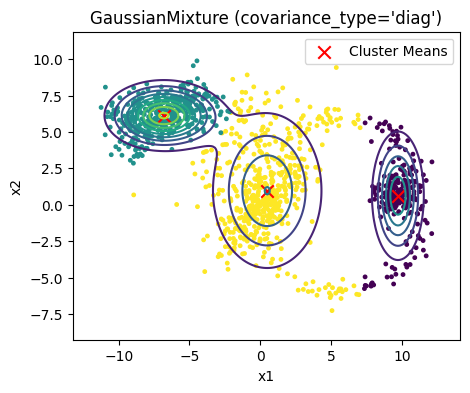

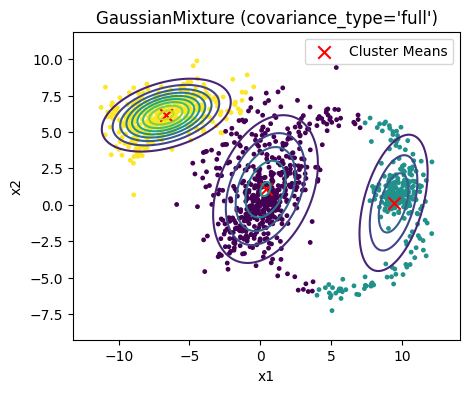

In [5]:
# ----- Comparison using scikit-learn's built-in GaussianMixture -----
if 'GaussianMixture' in globals():
    # Try both covariance types: 'diag' (diagonal) and 'full' (fully general)
    for cov in ['diag', 'full']:
        # Initialize a Gaussian Mixture Model from scikit-learn
        gm = GaussianMixture(
            n_components=K,        # Number of Gaussian components
            covariance_type=cov,   # Type of covariance matrix: 'diag' or 'full'
            n_init=5,              # Run EM multiple times with different initializations
            random_state=7         # Reproducibility
        )

        # Fit the GMM to data (EM is handled internally)
        gm.fit(X)

        # Predict cluster assignments (hard labels)
        labels = gm.predict(X)

        # ----- Create a 2D grid for visualization of the density -----
        x1min, x1max = X[:, 0].min() - 2.0, X[:, 0].max() + 2.0
        x2min, x2max = X[:, 1].min() - 2.0, X[:, 1].max() + 2.0
        xx, yy = np.meshgrid(
            np.linspace(x1min, x1max, 200),
            np.linspace(x2min, x2max, 200)
        )

        # Combine grid coordinates into shape (N_grid, 2)
        grid = np.c_[xx.ravel(), yy.ravel()]

        # Compute the (log) probability density of each grid point under the model
        zz = np.exp(gm.score_samples(grid)).reshape(xx.shape)

        # ----- Visualization -----
        plt.figure(figsize=(5, 4))

        # Contour plot of the Gaussian mixture density
        plt.contour(xx, yy, zz, levels=10, cmap='viridis')

        # Scatter plot of actual data points, colored by cluster assignment
        plt.scatter(X[:, 0], X[:, 1], s=6, c=labels, cmap='viridis')

        # Mark cluster centers (means)
        plt.scatter(
            gm.means_[:, 0], gm.means_[:, 1],
            marker='x', s=80, color='red', label='Cluster Means'
        )

        plt.title(f"GaussianMixture (covariance_type='{cov}')")
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()
        plt.show()
else:
    # Fallback if scikit-learn is not available
    print('scikit-learn not available: skipping GaussianMixture comparison.')

## 6. Picking \(K\): BIC / AIC

We’ll sweep \(K\) and plot BIC/AIC. Lower is better.

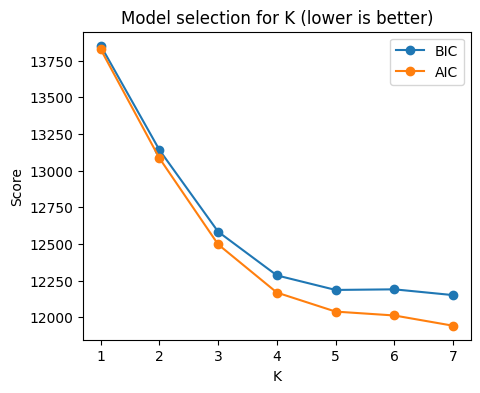

In [6]:
# ----- Model selection using BIC and AIC -----
if 'GaussianMixture' in globals():
    # Test different numbers of Gaussian components (K = 1 to 7)
    Ks = list(range(1, 8))
    bics, aics = [], []  # To store model selection scores

    # Loop over candidate numbers of clusters
    for k in Ks:
        # Create a Gaussian Mixture Model with a 'full' covariance
        gm = GaussianMixture(
            n_components=k,      # Number of mixture components
            covariance_type='full',  # Allow full covariance (most flexible)
            n_init=5,            # Multiple initializations for robustness
            random_state=7
        )

        # Fit model to the data
        gm.fit(X)

        # Compute information criteria
        bics.append(gm.bic(X))   # Bayesian Information Criterion
        aics.append(gm.aic(X))   # Akaike Information Criterion

    # ----- Plot AIC and BIC versus number of components -----
    plt.figure(figsize=(5, 4))
    plt.plot(Ks, bics, marker='o', label='BIC')
    plt.plot(Ks, aics, marker='o', label='AIC')
    plt.title('Model selection for K (lower is better)')
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.legend()
    plt.show()
else:
    # Skip if GaussianMixture is unavailable
    print('scikit-learn not available: skipping BIC/AIC sweep.')

## 7. Inspect Responsibilities (Soft Assignments)

Each row of the responsibility matrix $R = [r_{ik}]$ sums to 1 over components $k$. Below, we print a small slice to see how some points are split across clusters.

In [7]:
# ----- Inspecting the responsibilities matrix -----
R = gmm_iso['responsibilities']  # (N, K) matrix of soft cluster assignments
print('Responsibilities shape:', R.shape)
# Each row corresponds to one data point, and each column to one Gaussian component.
# Entry R[n, k] = posterior probability that sample n belongs to component k.

print('First 5 rows (sum over k should be 1):')
np.set_printoptions(precision=3, suppress=True)  # Format numbers nicely (3 decimals, no scientific notation)
print(R[:5])  # Display first 5 samples’ soft assignments

# Verify normalization: each row should sum to approximately 1 (since they represent probabilities)
print('Row sums (first 5):', R[:5].sum(axis=1))

Responsibilities shape: (1200, 3)
First 5 rows (sum over k should be 1):
[[0.017 0.983 0.   ]
 [0.999 0.    0.001]
 [0.872 0.    0.128]
 [0.004 0.    0.996]
 [0.016 0.    0.984]]
Row sums (first 5): [1. 1. 1. 1. 1.]


## 8. Your Turn — Mini‑Experiments

1. **Initialization sensitivity:** Re‑run EM with different seeds or with `init="random"`. How do the log‑likelihood and clusters change?
2. **Scale matters:** Standardize features and re‑run (hint: subtract mean and divide by std). How does this affect variances and assignments?
3. **Misspecified variance:** Modify the code to use a fixed shared variance $\sigma^2$ instead of learning it. Compare results.
4. **Diagonal vs full covariances:** Extend the M‑step to learn diagonal covariances. Then compare to `GaussianMixture(covariance_type="diag")`.

## Appendix — M‑Step (Isotropic) Sketch

Given responsibilities $r_{ik}$ and soft counts $N_k = \sum_i r_{ik}$:  
$\mu_k = \frac{1}{N_k} \sum_i r_{ik} x_i$,  $\pi_k = \frac{N_k}{N}$,  $\sigma_k^2 = \frac{1}{d N_k} \sum_i r_{ik} \lVert x_i - \mu_k \rVert^2$.  

These come from maximizing the expected complete‑data log‑likelihood with respect to parameters under the constraints (e.g., $\sum_k \pi_k = 1$).